In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from itertools import cycle


In [108]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

In [109]:
# Load the dataset
try:
    df = pd.read_csv("cleaned_sleep_health_data.csv")
except FileNotFoundError:
    print("Error: 'cleaned_sleep_health_data.csv' not found. Please ensure the file is in the working directory.")
    exit()

In [110]:
# Verify required columns
required_cols = ["Gender", "Occupation", "BMI Category", "Age", "Sleep Duration", 
                "Stress Level", "Physical Activity Level", "Heart Rate", "Daily Steps", "Sleep Disorder"]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Missing columns in dataset: {missing_cols}")
    exit()


In [111]:
# Preprocessing
# Encode categorical variables
le = LabelEncoder()
cat_cols = ["Gender", "Occupation", "BMI Category", "Sleep Disorder"]
for col in cat_cols:
    df[col + "_Encoded"] = le.fit_transform(df[col])


In [112]:
# Define features and target
num_cols = ["Age", "Sleep Duration", "Stress Level", "Physical Activity Level", "Heart Rate", "Daily Steps"]
features = num_cols + [col + "_Encoded" for col in cat_cols[:-1]]  # Exclude target
target = "Sleep Disorder_Encoded"
X = df[features]
y = df[target]


In [113]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [114]:
# Basic Data Overview
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df[num_cols].describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           155 non-null    object 
 11  Systolic_BP              374 non-null    int64  
 12  Diastolic_BP             374 non-null    int64  
 13  Gender_Encoded           374 non-null    int64  
 14  Occupation_E

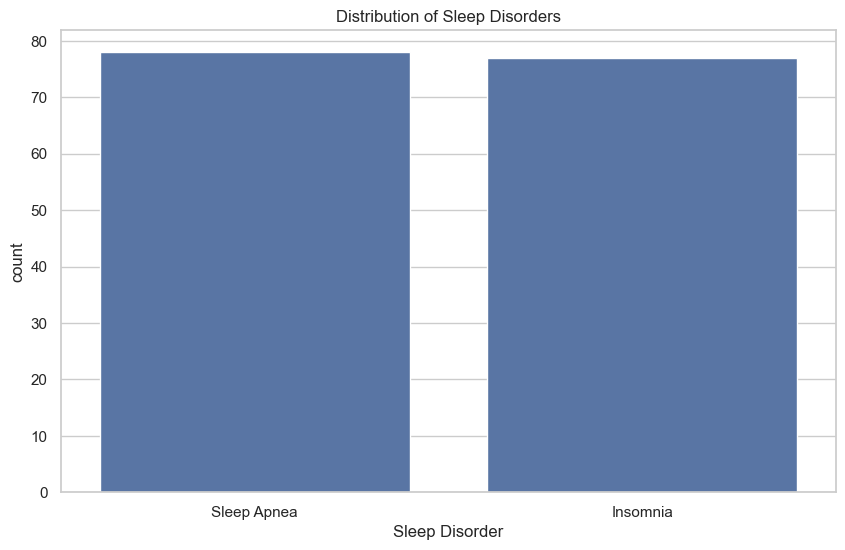

In [116]:
# Advanced EDA: Visualizations
# 1. Distribution of Sleep Disorders
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Sleep Disorder")
plt.title("Distribution of Sleep Disorders")
plt.show("sleep_disorder_distribution.png")
plt.close()

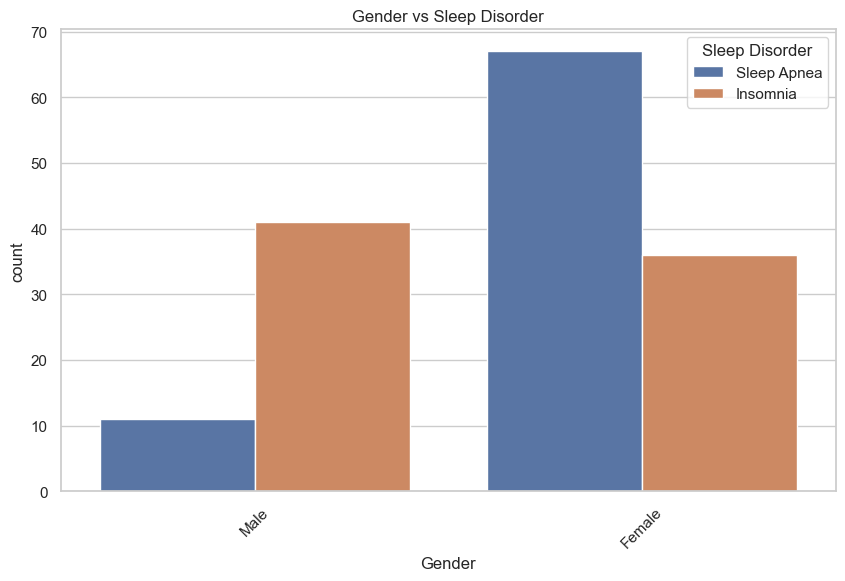

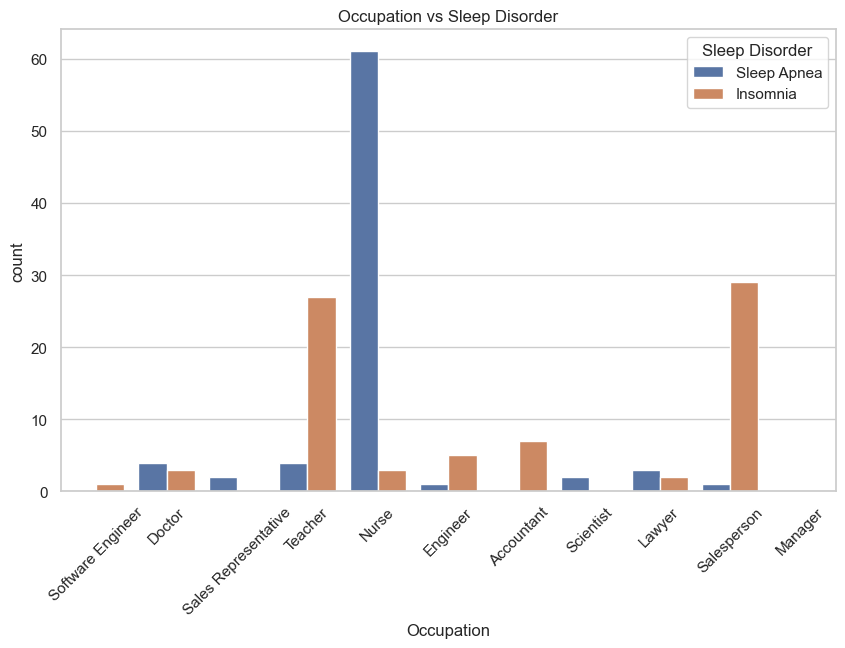

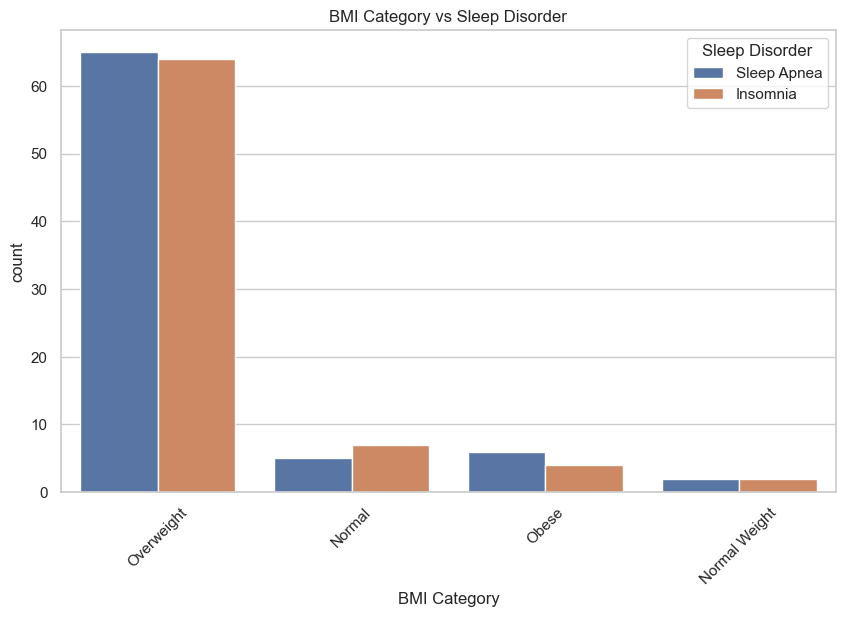

In [117]:
# 2. Categorical vs Sleep Disorder
for col in cat_cols[:-1]:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue="Sleep Disorder")
    plt.title(f"{col} vs Sleep Disorder")
    plt.xticks(rotation=45)
    plt.show(f"{col}_vs_sleep_disorder.png")
    plt.close()

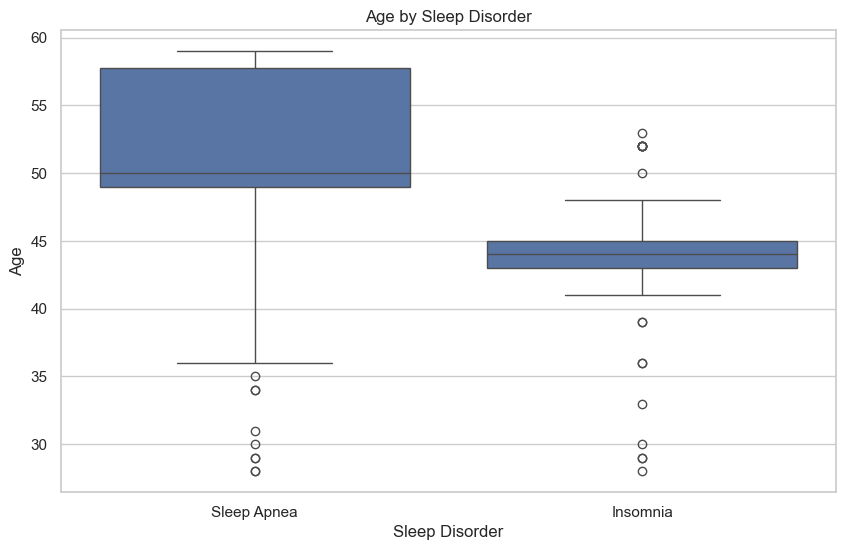

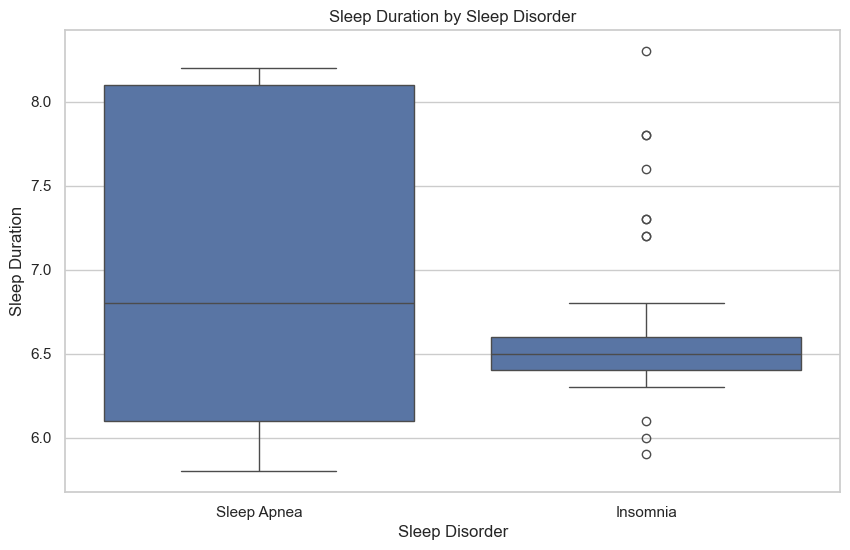

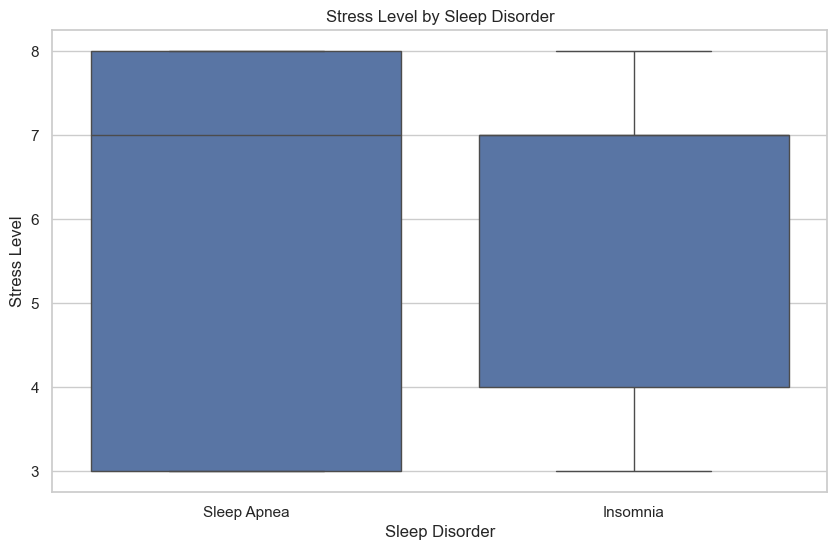

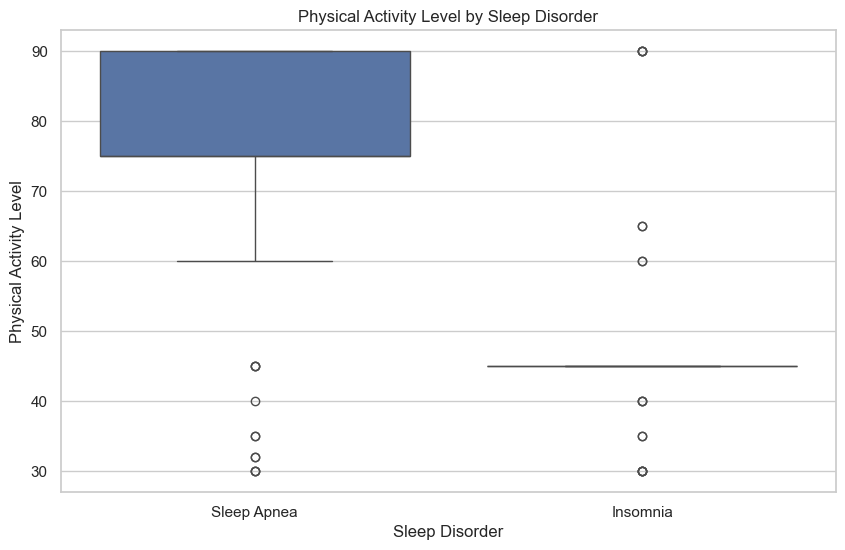

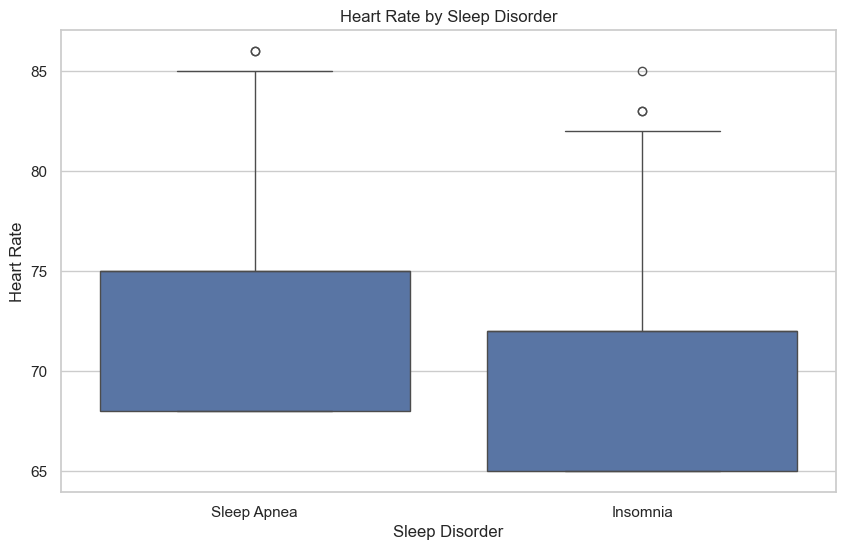

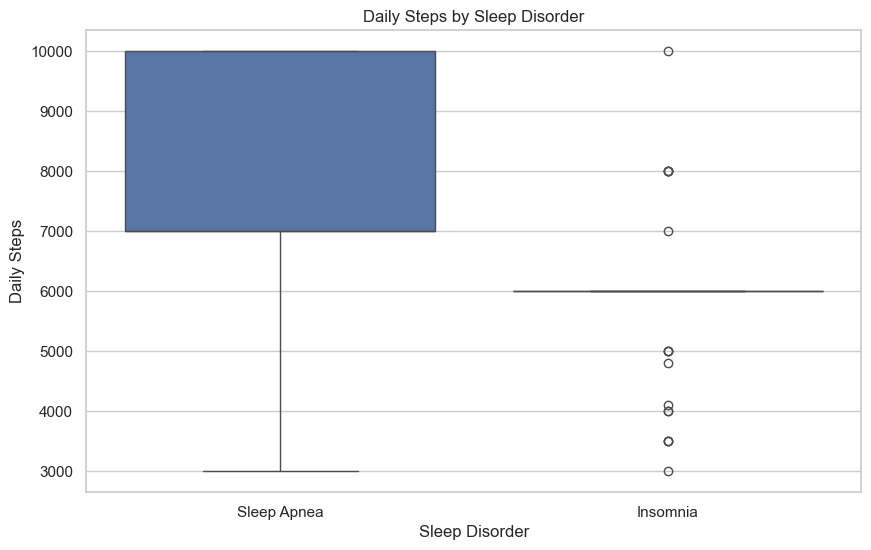

In [118]:

# 3. Numerical Features by Sleep Disorder
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Sleep Disorder", y=col)
    plt.title(f"{col} by Sleep Disorder")
    plt.show(f"{col}_by_sleep_disorder.png")
    plt.close()

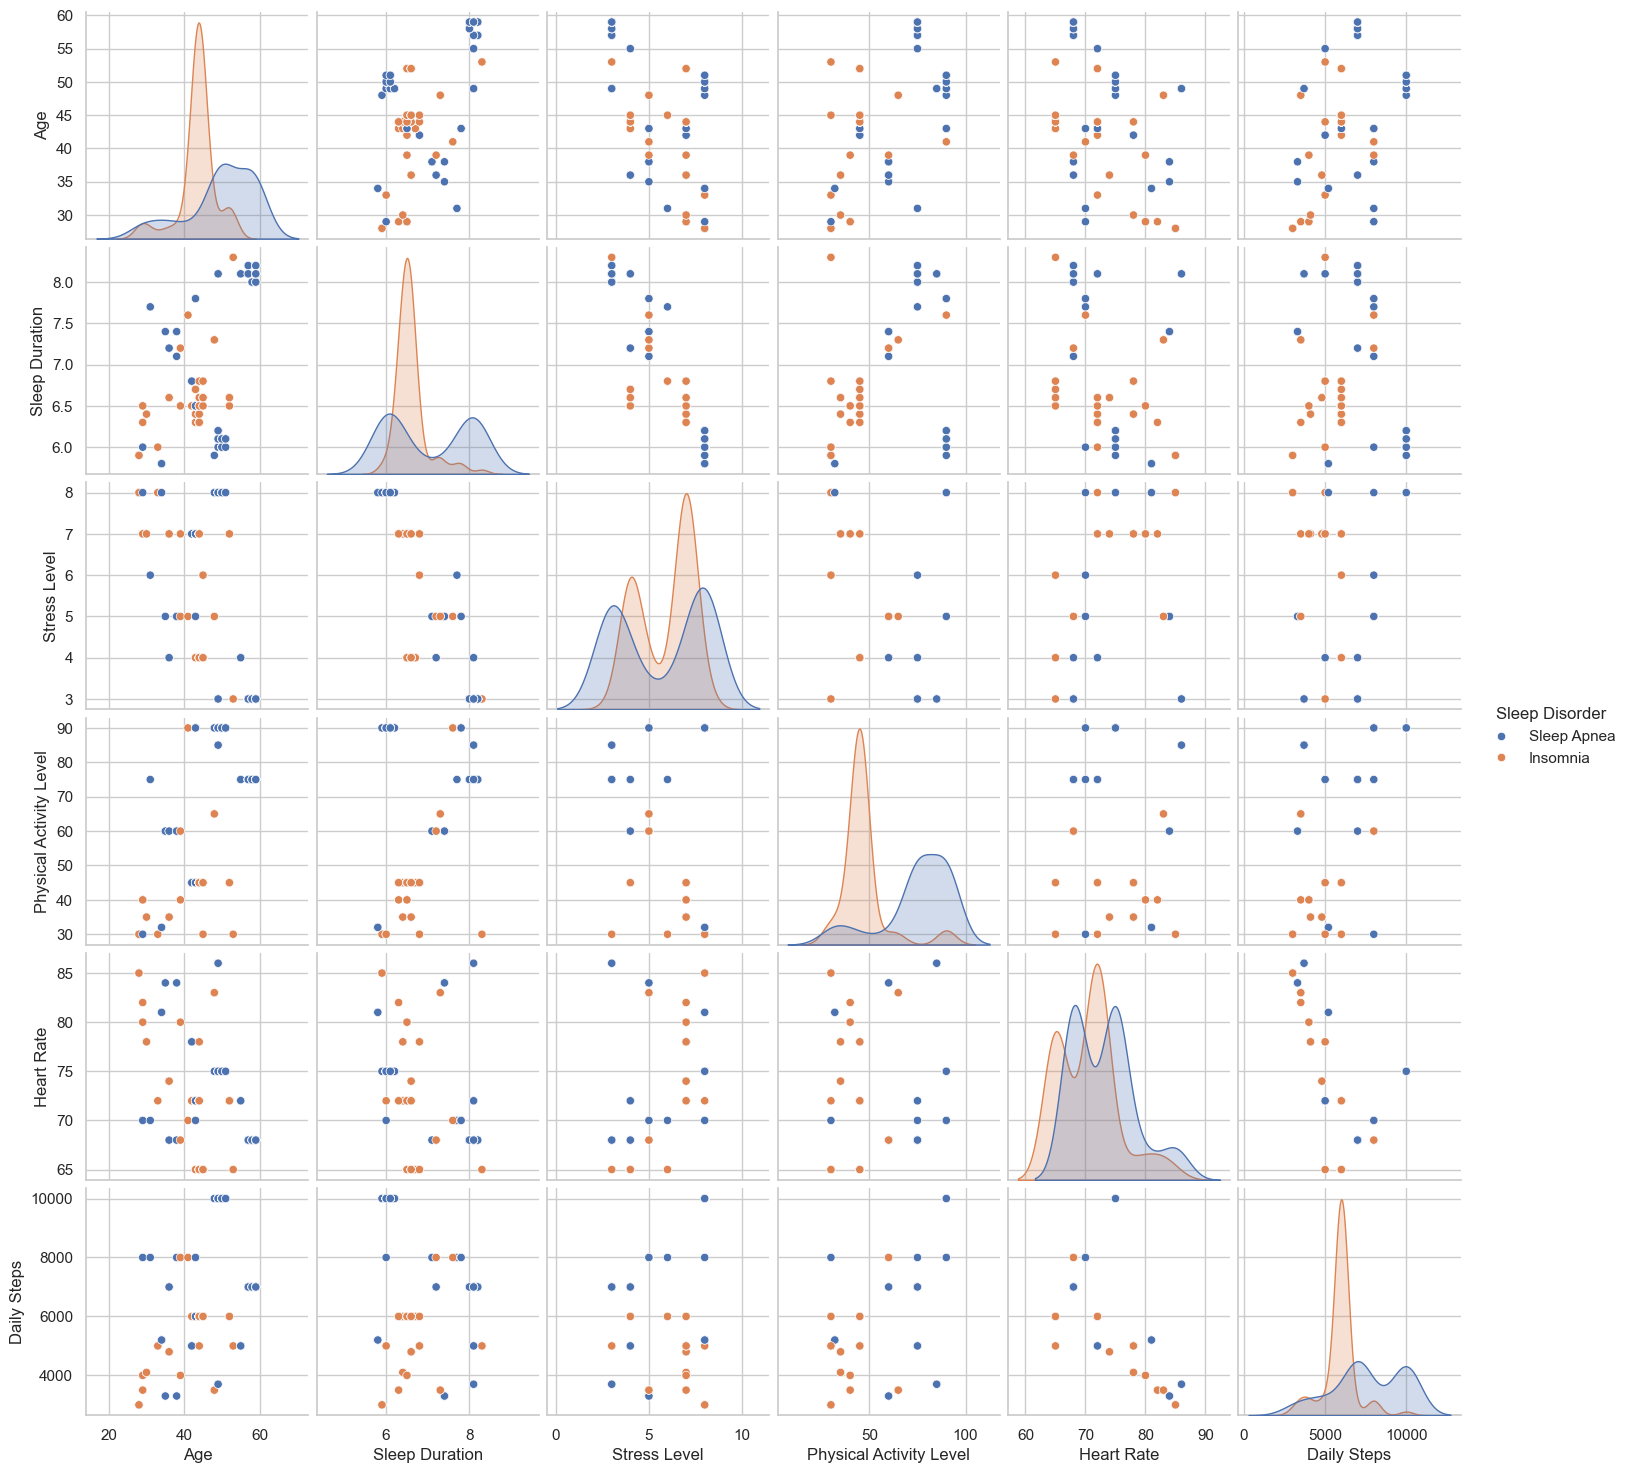

In [119]:
# 4. Pair Plot for Numerical Features
sns.pairplot(df[num_cols + ["Sleep Disorder"]], hue="Sleep Disorder", diag_kind="kde")
plt.show("pairplot_numerical.png")
plt.close()

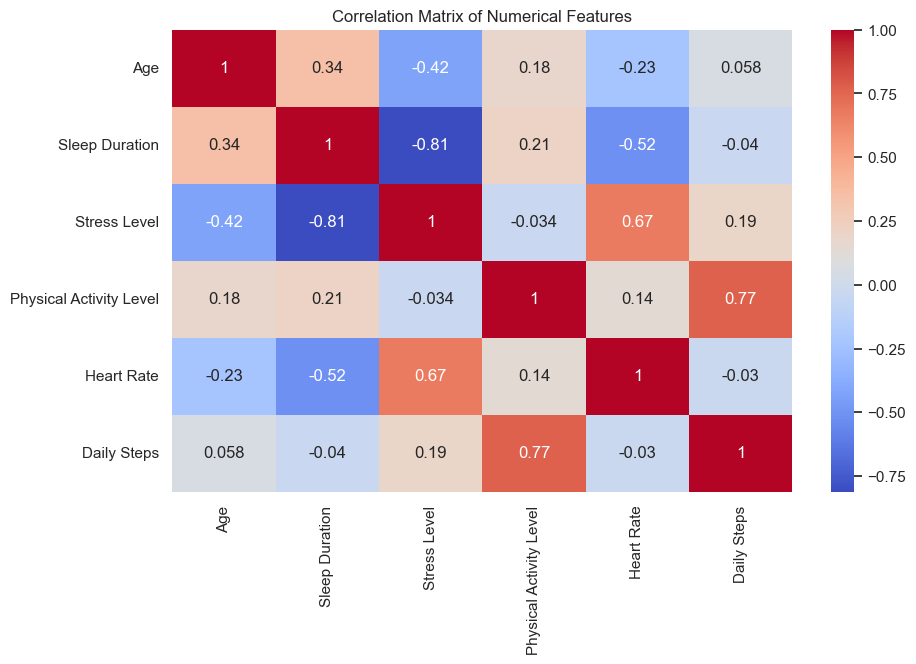

In [121]:
# 5. Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show("correlation_matrix.png")
plt.close()

In [122]:
# Statistical Analysis
# 1. Chi-Square Test for Categorical Variables
def chi_square_test(df, col, target="Sleep Disorder"):
    table = pd.crosstab(df[col], df[target])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"\nChi-Square Test for {col} vs {target}:")
    print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print(f"✅ Significant association between {col} and {target}")
    else:
        print(f"❌ No significant association between {col} and {target}")

for col in cat_cols[:-1]:
    chi_square_test(df.dropna(subset=["Sleep Disorder"]), col)


Chi-Square Test for Gender vs Sleep Disorder:
Chi2 Statistic: 24.91, p-value: 0.0000
✅ Significant association between Gender and Sleep Disorder

Chi-Square Test for Occupation vs Sleep Disorder:
Chi2 Statistic: 110.77, p-value: 0.0000
✅ Significant association between Occupation and Sleep Disorder

Chi-Square Test for BMI Category vs Sleep Disorder:
Chi2 Statistic: 0.73, p-value: 0.8650
❌ No significant association between BMI Category and Sleep Disorder


In [123]:
# 2. ANOVA for Numerical Features
def anova_test(df, feature, target="Sleep Disorder"):
    groups = [group[feature].dropna() for name, group in df.groupby(target)]
    stat, p = f_oneway(*groups)
    print(f"\nANOVA for {feature} vs {target}:")
    print(f"F-statistic: {stat:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print(f"✅ Significant difference in {feature} across {target} groups")
    else:
        print(f"❌ No significant difference in {feature} across {target} groups")

for col in num_cols:
    anova_test(df.dropna(subset=["Sleep Disorder"]), col)


ANOVA for Age vs Sleep Disorder:
F-statistic: 28.42, p-value: 0.0000
✅ Significant difference in Age across Sleep Disorder groups

ANOVA for Sleep Duration vs Sleep Disorder:
F-statistic: 13.72, p-value: 0.0003
✅ Significant difference in Sleep Duration across Sleep Disorder groups

ANOVA for Stress Level vs Sleep Disorder:
F-statistic: 0.42, p-value: 0.5171
❌ No significant difference in Stress Level across Sleep Disorder groups

ANOVA for Physical Activity Level vs Sleep Disorder:
F-statistic: 131.67, p-value: 0.0000
✅ Significant difference in Physical Activity Level across Sleep Disorder groups

ANOVA for Heart Rate vs Sleep Disorder:
F-statistic: 10.51, p-value: 0.0015
✅ Significant difference in Heart Rate across Sleep Disorder groups

ANOVA for Daily Steps vs Sleep Disorder:
F-statistic: 39.94, p-value: 0.0000
✅ Significant difference in Daily Steps across Sleep Disorder groups


In [124]:
# 3. T-test: Sleep Duration between Insomnia and Sleep Apnea
df_insomnia = df[df["Sleep Disorder"] == "Insomnia"]
df_apnea = df[df["Sleep Disorder"] == "Sleep Apnea"]
t_stat, p_val = ttest_ind(df_insomnia["Sleep Duration"].dropna(), df_apnea["Sleep Duration"].dropna())
print(f"\nT-test: Sleep Duration between Insomnia and Sleep Apnea:")
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")


T-test: Sleep Duration between Insomnia and Sleep Apnea:
T-statistic: -3.70, p-value: 0.0003


In [129]:
# Classification Models
models = {
    "Logistic Regression": LogisticRegression(multi_class="ovr", random_state=42, max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

# Store results
results = {}
roc_data = {}
class_names = [str(cls) for cls in le.classes_]  # Ensure class names are strings

# Train and evaluate each model
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))


Logistic Regression Performance:
Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.74      0.88      0.80        16
 Sleep Apnea       0.92      0.69      0.79        16
         nan       0.91      0.93      0.92        43

    accuracy                           0.87        75
   macro avg       0.85      0.83      0.84        75
weighted avg       0.87      0.87      0.87        75


Naive Bayes Performance:
Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.67      0.88      0.76        16
 Sleep Apnea       0.92      0.69      0.79        16
         nan       0.95      0.93      0.94        43

    accuracy                           0.87        75
   macro avg       0.85      0.83      0.83        75
weighted avg       0.88      0.87      0.87        75


SVM Performance:
Accuracy: 0.6400
Classification Report:
              precision    recall  f1-sc

In [137]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"confusion_matrix_{name.lower().replace(' ', '_')}.png")
    plt.close()
    y_score = model.predict_proba(X_test) if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    results[name] = accuracy
    roc_data[name] = (fpr, tpr, roc_auc)


Logistic Regression Performance:
Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.74      0.88      0.80        16
 Sleep Apnea       0.92      0.69      0.79        16
         nan       0.91      0.93      0.92        43

    accuracy                           0.87        75
   macro avg       0.85      0.83      0.84        75
weighted avg       0.87      0.87      0.87        75


Naive Bayes Performance:
Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.67      0.88      0.76        16
 Sleep Apnea       0.92      0.69      0.79        16
         nan       0.95      0.93      0.94        43

    accuracy                           0.87        75
   macro avg       0.85      0.83      0.83        75
weighted avg       0.88      0.87      0.87        75


SVM Performance:
Accuracy: 0.6400
Classification Report:
              precision    recall  f1-sc

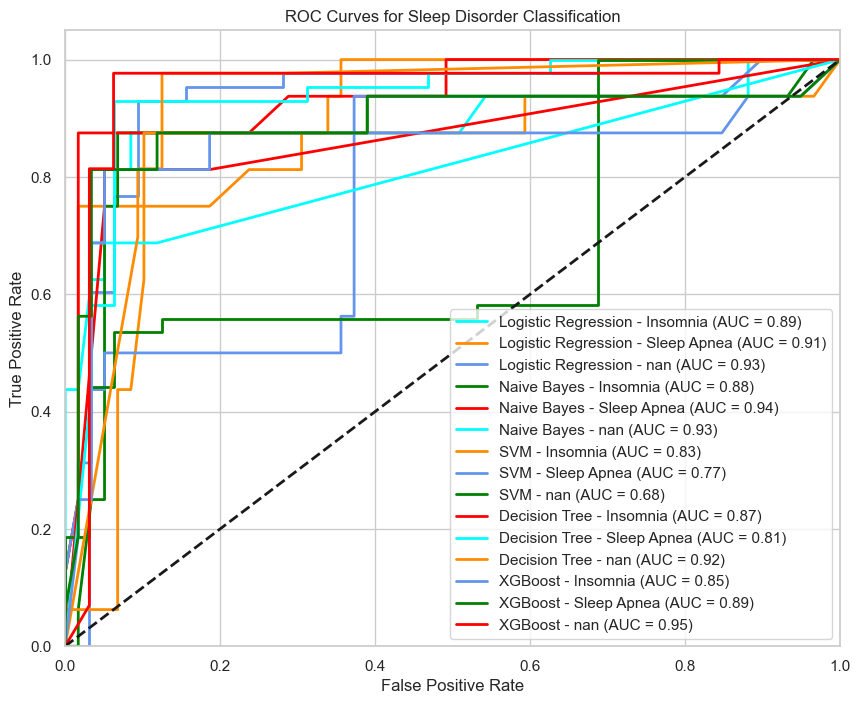

In [138]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for name, (fpr, tpr, roc_auc) in roc_data.items():
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{name} - {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sleep Disorder Classification')
plt.legend(loc="lower right")
plt.show("roc_curves_all_models.png")
plt.close()